# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
## RUN IN COLAB or REWRITE IT FOR THE GPU IN USE ##

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
'Colab Notebooks'  'Colab Notebooks_trashed'   Train_rev1.zip


In [0]:
!cp '/content/gdrive/My Drive/Train_rev1.zip' .
!ls

gdrive	sample_data  Train_rev1.zip


In [0]:
data = pd.read_csv("./Train_rev1.zip", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)['FullDescription']

213112    Urgently needed, an experienced and personable...
230277    Are you a Recruitment Manager looking for your...
201323    Salary  ****  **** p.a. (includes market suppl...
Name: FullDescription, dtype: object

In [0]:
data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
244365,72696016,Directory Sales Executive,"Our client, a dynamic Publishing Company, are ...",Maidstone,Maidstone,NaN,permanent,Blue Arrow High Street Maidstone,Sales Jobs,15000 to 18000,16500,jobsite.co.uk,9.711176
126856,70014345,Talent Manager (Elearning),My client a leading professional services firm...,"City of London, England",The City,full_time,contract,Frazer Jones,HR & Recruitment Jobs,50000 - 60000 per annum,55000,peoplemanagement.co.uk,10.915107
198071,71846343,PASTRY CHEF DE PARTIE OXFORDSHIRE ****AA ROSET...,PASTRY CHEF OXFORDSHIRE ********K TIPS LIVE I...,Abingdon Oxfordshire South East,Abingdon,NaN,permanent,Support Services Group,Hospitality & Catering Jobs,"From 18,000 to 23,000 per annum 23K + LIVE IN ...",20500,totaljobs.com,9.928229


In [0]:
# Title
print(data['Title'][1])
# Description
data['FullDescription'][1]

Stress Engineer Glasgow


'Stress Engineer Glasgow Salary **** to **** We re currently looking for talented engineers to join our growing Glasgow team at a variety of levels. The roles are ideally suited to high calibre engineering graduates with any level of appropriate experience, so that we can give you the opportunity to use your technical skills to provide high quality input to our aerospace projects, spanning both aerostructures and aeroengines. In return, you can expect good career opportunities and the chance for advancement and personal and professional development, support while you gain Chartership and some opportunities to possibly travel or work in other offices, in or outside of the UK. The Requirements You will need to have a good engineering degree that includes structural analysis (such as aeronautical, mechanical, automotive, civil) with some experience in a professional engineering environment relevant to (but not limited to) the aerospace sector. You will need to demonstrate experience in at

### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [0]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [0]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [0]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


In [0]:
len(data) / 1000

244.768

Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [0]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
groups = np.arange(len(data)) // 1000
for _, batch in data["Title"].groupby(groups):
    token_counts.update(np.concatenate(batch.str.split().values))
for _, batch in data["FullDescription"].groupby(groups):
    token_counts.update(np.concatenate(batch.str.split().values))


In [0]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


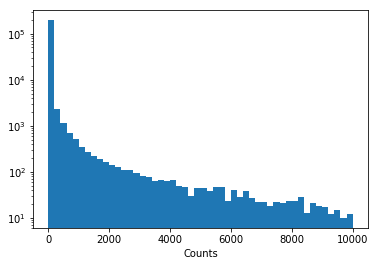

In [0]:
# Let's see how many words are there for each count

_ = plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [0]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [x for x in token_counts.keys() if token_counts[x] > min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [0]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 32456
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [0]:
token_to_id = {w: i for i, w in enumerate(tokens)} #<your code here>

In [0]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [0]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [0]:
#### print("Lines:")
print('unk and pad idcs', UNK_IX, PAD_IX)
print()
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

unk and pad idcs 0 1

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 996  176    1    1    1]
 [  18 3461  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [0]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

In [0]:
data[categorical_columns].apply(dict, axis=1)[0]

{'Category': 'Engineering Jobs',
 'Company': 'Gregory Martin International',
 'ContractTime': 'permanent',
 'ContractType': 'NaN',
 'LocationNormalized': 'Dorking'}

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [0]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [0]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'col1' : int64[batch, col1_max_len],
                           'col2' : int64[.....]}
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(
        data[categorical_columns].apply(dict, axis=1)
    )
    
    if target_column in data.columns: # target column = "Log1pSalary"
        batch[target_column] = data[target_column].values
    
    return batch

In [0]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[3189,  558,  559,  942,   73,  561,  229, 6350,  345, 1751],
        [2490,   46,   47,  704, 6682,  521,   55,  168, 2235, 1825],
        [1544,   86,  142,    2,   88,  211, 1242, 3152, 2927, 3171]],
       dtype=int32),
 'Log1pSalary': array([10.187575, 10.257694, 10.532123], dtype=float32),
 'Title': array([[1751, 1067,  442,  543],
        [ 165,   88, 1280,    1],
        [  70,    2,  531,    1]], dtype=int32)}

### Finally, let's talk deep learning

Our model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super().__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [0]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super().__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense1 = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        #<YOUR CODE HERE>
        h = self.pool1(self.conv1(h))
        h = self.dense1(F.relu(h))
        
        return torch.sigmoid(h)

In [0]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [0]:
# THE BEST OVER 100 EPOCHS
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super().__init__()
        emb_size=64
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=PAD_IX)
        
        self.conv1 = nn.Conv1d(emb_size, out_size, kernel_size=7, padding=3)
        self.conv2 = nn.Conv1d(out_size, out_size, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(out_size, out_size, kernel_size=3, padding=1)

        self.pool1 = GlobalMaxPooling()        
        self.dense1 = nn.Linear(3 * out_size, out_size, bias=False)
        self.bn = nn.BatchNorm1d(out_size)
        self.dense2 = nn.Linear(out_size, out_size)
    
    def forward(self, text_ix):
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        
        out_conv1 = F.relu(self.conv1(h))
        out_conv2 = F.relu(self.conv2(h))
        out_conv3 = F.relu(self.conv3(h))
      
        h = torch.cat([out_conv1, out_conv2, out_conv3], dim=1)
        
        h = F.relu(self.pool1(h))
        h = self.bn(self.dense1(h))
        h = self.dense2(F.relu(h))
        
        return torch.sigmoid(h)

In [0]:
# THE EASIEST VERSION OF A NET WITH PARALLEL CONVOLUTIONS

# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
#<YOUR CODE HERE>
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super().__init__()
        emb_size = 64
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=PAD_IX)
        
        self.conv1 = nn.Conv1d(emb_size, out_size, kernel_size=7, padding=3)
        self.conv2 = nn.Conv1d(out_size, out_size, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(out_size, out_size, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(out_size, out_size, kernel_size=3, padding=1)

        self.pool1 = GlobalMaxPooling()        
        self.dense1 = nn.Linear(3 * out_size, out_size)
        self.dense2 = nn.Linear(out_size, out_size)
    
    def forward(self, text_ix):
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        
        out_conv1 = F.relu(self.conv1(h))
        out_conv2 = F.relu(self.conv2(h))
        out_conv3 = F.relu(self.conv3(h))
      
        out_conv1 = self.conv4(out_conv1)
        out_conv2 = self.conv4(out_conv2)
        out_conv3 = self.conv4(out_conv3)
        h = torch.cat([out_conv1, out_conv2, out_conv3], dim=1)
        
        h = self.pool1(h)
        h = self.dense1(F.relu(h))
        h = self.dense2(F.relu(h))
        
        return torch.sigmoid(h)

In [0]:
# ITS MODIFIED VERSION

# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
#<YOUR CODE HERE>
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super().__init__()
        emb_size = 64
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=PAD_IX)
        
        self.conv1 = nn.Conv1d(emb_size, out_size, kernel_size=7, padding=3)
        self.conv2 = nn.Conv1d(out_size, out_size, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(out_size, out_size, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(out_size, out_size, 
                               kernel_size=3, padding=1, bias=False)
        
        self.bn = nn.BatchNorm1d(out_size)

        self.pool1 = GlobalMaxPooling()        
        self.dense1 = nn.Linear(3 * out_size, out_size)
        self.dense2 = nn.Linear(out_size, out_size)
    
    def forward(self, text_ix):
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        
        out_conv1 = F.elu(self.conv1(h))
        out_conv2 = F.elu(self.conv2(h))
        out_conv3 = F.elu(self.conv3(h))
      
        out_conv1 = self.conv4(self.bn(out_conv1))
        out_conv2 = self.conv4(self.bn(out_conv2))
        out_conv3 = self.conv4(self.bn(out_conv3))
        h = torch.cat([out_conv1, out_conv2, out_conv3], dim=1)
        
        h = F.elu(self.pool1(h))
        
        h = self.dense1(h)
        h = self.dense2(F.elu(h))
        
        return torch.sigmoid(h)

In [0]:
# BIDIRECTIONAL LSTM WITH ATTENTIVE POOLING

#<YOUR CODE HERE>
class AttentivePooling(nn.Module):
    def __init__(self, n_units, emb_size=128, 
                 n_spots=64, dim=-1):
        super().__init__()
        self.A = nn.Sequential(
            nn.Linear(n_units, emb_size),
            nn.Tanh(),
            nn.Linear(emb_size, n_spots),
            nn.Softmax(dim)
        )
        
    """
    Доработать
    def forward(self, H):
        W = nn.nn.Parameter(torch.Tensor())
        Y = W @ H
        G = torch.einsum('ijr,ikr->ijk', Y, Y)
        
        mask = torch.eye(G.size(1)).byte()
        if H.is_cuda:
            mask = mask.to(device)
        G = G.masked_fill(mask, 0)
        g = G.max(1)[0]
        A = g.softmax(-1)
        """
        
    
    def forward(self, H):
        return torch.einsum('ikr,ikq->iq', self.A(H), H)
          

class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super().__init__()
        emb_size = 64
        lstm_units = 128        
        
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=PAD_IX)
        self.lstm = nn.LSTM(emb_size, lstm_units, 
                            batch_first=True, bidirectional=True)
        self.attn_pool = AttentivePooling(2 * lstm_units)
        self.fc = nn.Linear(2 * lstm_units, out_size)
    
    def forward(self, text_ix):
        words_emb = self.emb(text_ix)
        out_lstm, _  = self.lstm(words_emb)
        fs = self.attn_pool(out_lstm)
        h = self.fc(fs)
        
        return torch.sigmoid(h)

In [0]:
desc_encoder = DescriptionEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3, max_len=1000)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__Task 2.2__ Build one network ~~to rule them all~~

In [0]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super().__init__()
        
        outT = 64
        outD = 64
        self.title_encoder = TitleEncoder(out_size=outT)
        self.descr_encoder = DescriptionEncoder(out_size=outD) #<YOUR CODE>
        
        # define layers for categorical features. A few dense layers would do.
        #<YOUR CODE>
        Nhid = 200
        outC = 64
        self.fc_cat_1 = nn.Linear(n_cat_features, Nhid)
        self.fc_cat_2 = nn.Linear(Nhid, outC)
        
        
        # define "output" layers that process depend the three encoded vectors into answer
        #<YOUR CODE>
        dimZ = 100
        self.fc_out_1 = nn.Linear(outT + outD + outC, dimZ)
        self.fc_out_2 = nn.Linear(dimZ, 1)
        
        
    def forward(self, title_ix, descr_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param descr_ix:  int32 Variable [batch, descr_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """

        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        descr_h = self.descr_encoder(descr_ix)
        
        # apply categorical encoder <YOUR CODE>
        cat_h = F.relu(self.fc_cat_1(cat_features))
        cat_h = F.relu(self.fc_cat_2(cat_h))
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, descr_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top <YOUR CODE>
        out = F.relu(self.fc_out_1(joint_h))
        out = self.fc_out_2(out)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return torch.squeeze(out) # or out[:, 0] #<YOUR CODE>

In [0]:
model = FullNetwork()
model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
descr_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()

prediction = model(title_ix, descr_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [0]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [0]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [0]:
import copy
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [0]:
num_epochs = 200
max_len = 100
batch_size = 64
batches_per_epoch = 120

In [0]:
%%time
val_mae_history, val_loss_history = [], []
best_model_wts = copy.deepcopy(model.state_dict())
best_val_mae = np.inf
for epoch_i in range(num_epochs):
    print("EPOCH: %i" % epoch_i)
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, 
                                     max_batches=batches_per_epoch,
                                     verbose=False
                                    ):
        title_ix = torch.tensor(batch["Title"],
                                dtype=torch.int64).cuda()
        desc_ix = torch.tensor(batch["FullDescription"],
                               dtype=torch.int64).cuda()
        cat_features = torch.tensor(batch["Categorical"],
                                    dtype=torch.float32).cuda()
        reference = torch.tensor(batch[target_column], 
                                 dtype=torch.float32).cuda()

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.item()
        train_mae += compute_mae(reference, prediction).item()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, 
                                     shuffle=False,
                                     verbose=False
                                    ):
        title_ix = torch.tensor(batch["Title"], 
                                dtype=torch.int64).cuda()
        desc_ix = torch.tensor(batch["FullDescription"], 
                               dtype=torch.int64).cuda()
        cat_features = torch.tensor(batch["Categorical"], 
                                    dtype=torch.float32).cuda()
        reference = torch.tensor(batch[target_column], 
                                 dtype=torch.float32).cuda()
        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.item()
        val_mae += compute_mae(reference, prediction).item()
        val_batches += 1
    
    val_mae  /= val_batches
    val_loss /= val_batches
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        print('\nBEST: %.3f' % best_val_mae)
        best_model_wts = copy.deepcopy(model.state_dict())
        
    ## collecting losses
    val_mae_history.append(val_mae)
    val_loss_history.append(val_loss)
    ## -----------------
    print("\tLoss:\t%.5f" % (val_loss))
    print("\tMAE:\t%.3f" % (val_mae))
    print('\n\n')

EPOCH: 0
Training:
	Loss:	16.41233
	MAE:	11764.46119



Validation:

BEST: 4518.418
	Loss:	0.22354
	MAE:	4518.418



EPOCH: 1
Training:
	Loss:	0.19643
	MAE:	4239.28653



Validation:

BEST: 3849.814
	Loss:	0.16522
	MAE:	3849.814



EPOCH: 2
Training:
	Loss:	0.15523
	MAE:	3799.63795



Validation:

BEST: 3669.263
	Loss:	0.14873
	MAE:	3669.263



EPOCH: 3
Training:
	Loss:	0.15019
	MAE:	3648.45025



Validation:

BEST: 3574.023
	Loss:	0.13900
	MAE:	3574.023



EPOCH: 4
Training:
	Loss:	0.14051
	MAE:	3513.25623



Validation:

BEST: 3477.039
	Loss:	0.13337
	MAE:	3477.039



EPOCH: 5
Training:
	Loss:	0.13175
	MAE:	3496.08314



Validation:

BEST: 3447.732
	Loss:	0.12942
	MAE:	3447.732



EPOCH: 6
Training:
	Loss:	0.13093
	MAE:	3458.24254



Validation:
	Loss:	0.13363
	MAE:	3544.864



EPOCH: 7
Training:
	Loss:	0.12031
	MAE:	3399.54773



Validation:

BEST: 3332.147
	Loss:	0.12119
	MAE:	3332.147



EPOCH: 8
Training:
	Loss:	0.12425
	MAE:	3373.79435



Validation:

BEST: 3230.554
	Loss:	0.115

KeyboardInterrupt: ignored

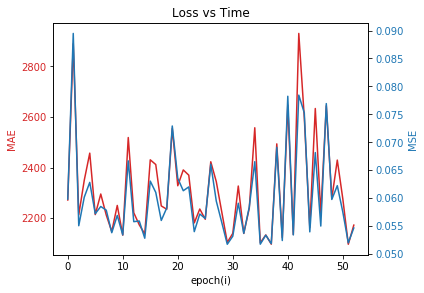

In [0]:
fig, ax1 = plt.subplots()
c = ['tab:red', 'tab:blue']

ax1.plot(val_mae_history, c=c[0])
ax1.set_xlabel('epoch(i)')
ax1.set_ylabel('MAE', color=c[0])
ax1.tick_params('y', labelcolor=c[0])

ax2 = ax1.twinx()
ax2.plot(val_loss_history, c=c[1])
ax2.set_ylabel('MSE', color=c[1])
ax2.tick_params('y', labelcolor=c[1])

fig.tight_layout() #doesn't do much here
ax1.set_title("Loss vs Time");

# USING CONVOLUTIONAL LAYERS *MODIFIED CELL* (LOOKS VERY PROMISING)
# rerun the entire pipeline for this cell 
# (the plot below produced after 2nd accidental exectution of 'train cell')

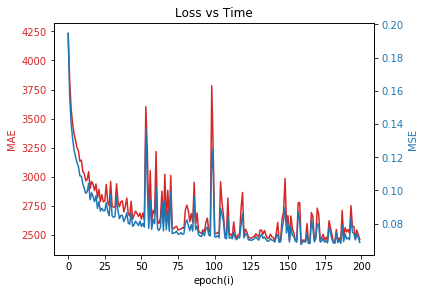

In [0]:
fig, ax1 = plt.subplots()
c = ['tab:red', 'tab:blue']

ax1.plot(val_mae_history, c=c[0])
ax1.set_xlabel('epoch(i)')
ax1.set_ylabel('MAE', color=c[0])
ax1.tick_params('y', labelcolor=c[0])

ax2 = ax1.twinx()
ax2.plot(val_loss_history, c=c[1])
ax2.set_ylabel('MSE', color=c[1])
ax2.tick_params('y', labelcolor=c[1])

fig.tight_layout() #doesn't do much here
ax1.set_title("Loss vs Time");

# USING BIDIRECTIONAL LSTM WITH ATTENTIVE POOLING

In [0]:
model.load_state_dict(best_model_wts)
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], 
                            dtype=torch.int64).to(device)
    desc_ix = torch.tensor(batch["FullDescription"], 
                           dtype=torch.int64).to(device)
    cat_features = torch.tensor(batch["Categorical"], 
                                dtype=torch.float32).to(device)
    reference = torch.tensor(batch[target_column], 
                             dtype=torch.float32).to(device)

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.item()
    val_mae += compute_mae(reference, prediction).item()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:



	Loss:	0.07555
	MAE:	2595.90690





### Task 3: explaining network predictions

It's usually a good idea to understand what your model does before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

__Your task__ is to measure how does model prediction change if you replace certain tokens with UNKs. The core idea is that if dropping a word from text causes model to predict lower log-salary, than this word probably has positive contribution to salary (and vice versa).

In [0]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    
    # compute model prediction on sample (scalar float log-salary)
    #<YOUR CODE>
    batch = generate_batch(pd.DataFrame(dict(sample), index=[0]))
    title_ix = torch.tensor(batch["Title"], 
                            dtype=torch.int64).to(device)
    descr_ix = torch.tensor(batch["FullDescription"], 
                            dtype=torch.int64).to(device)
    cat_features = torch.tensor(batch["Categorical"], 
                                dtype=torch.float32).to(device)
    baseline_pred = model(title_ix, descr_ix, cat_features) 
    
    # for each i-th token in :col_name:, compute predictions on a copy of data
    # where i-th token is dropped (UNK) 
    #<YOUR CODE>
    context = pd.DataFrame(columns=sample.keys())
    sen_list = sample[col_name].split()
    for i in range(len(sen_list)):
        sample_copy = sample.copy()
        sen_list_copy = sen_list.copy()
        sen_list_copy[i] = UNK
        sen = ' '.join(sen_list_copy)
        sample_copy[col_name] = sen
        context.loc[i] = sample_copy.values
    batch = generate_batch(context)
    title_ix = torch.tensor(batch["Title"], 
                            dtype=torch.int64).to(device)
    descr_ix = torch.tensor(batch["FullDescription"], 
                            dtype=torch.int64).to(device)
    cat_features = torch.tensor(batch["Categorical"], 
                                dtype=torch.float32).to(device)
    predictions_without_word = model(title_ix, descr_ix, cat_features) 
    
    score_differences = [
        prediction - baseline_pred for prediction in predictions_without_word
    ]
    score_differences = list(map(torch.Tensor.item, score_differences))
    # return a list of pairs: [(token, score_difference)]
    return list(zip(sen_list, score_differences)) #<YOUR CODE>

In [0]:
# debugging area
sample = data.loc[np.random.randint(len(data))]
print("Input:", sample)

print()

tokens_and_weights = explain(model, sample, "FullDescription")
print(tokens_and_weights)

Input: Id                                                             71306526
Title                                   sql server developer portsmouth
FullDescription       brand new role has been created for a sql serv...
LocationRaw                             Portsmouth Hampshire South East
LocationNormalized                                           Portsmouth
ContractType                                                        NaN
ContractTime                                                  permanent
Company                                    Spectrum IT Recruitment  Ltd
Category                                                        IT Jobs
SalaryRaw                    25000 - 30000 per annum + company benefits
SalaryNormalized                                                  27500
SourceName                                                 cwjobs.co.uk
Log1pSalary                                                      10.222
Name: 167577, dtype: object

[('brand', -8.20159912109375

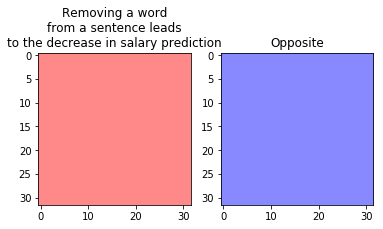

In [0]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html

ax = plt.subplot('121')
cmap = plt.get_cmap("bwr")
w = -1
mono = np.zeros((32, 32, 3))
mono[:,:] = cmap(1. / (1 + np.exp(w)))[:3]
plt.imshow(mono)
ax.set_title("""Removing a word
from a sentence leads
to the decrease in salary prediction""")


ax = plt.subplot('122')
w = 1
mono[:,:] = cmap(1. / (1 + np.exp(w)))[:3]
plt.imshow(mono)
ax.set_title("Opposite");

In [0]:
i = np.random.randint(len(data))
sample = data.loc[i]
print("Index:", i)

# predict salary on sample
batch = generate_batch(pd.DataFrame(dict(sample), index=[0]))
title_ix = torch.tensor(batch["Title"], 
                        dtype=torch.int64).cuda()
descr_ix = torch.tensor(batch["FullDescription"], 
                        dtype=torch.int64).cuda()
cat_features = torch.tensor(batch["Categorical"], 
                            dtype=torch.float32).cuda()
pred = model(title_ix, descr_ix, cat_features)
print("Salary (gbp):", pred)

tokens_and_weights = explain(model, sample, "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, sample, "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 127053
Salary (gbp): tensor(10.1054, device='cuda:0', grad_fn=<SqueezeBackward0>)


inspection & test engineer

position : inspection test engineer location : romsey salary : up to **** plus pension and profit related bonus working : **** hrs with half day friday my client is a market leader in design , development , manufacturing and testing of r d products for various industries and a worldwide clientele . reputation is key , so from their head office in romsey they test and inspect 100 % of the products manufactured and due to work flow are currently looking for an electro mechanical inspector and tester to join the current team . working with such a diverse and varied product range they require an adaptable engineer with the desire to work on products that integrate electronics , electrics , mechanics , pneumatics , hydraulics , fluid dynamics heat exchangers , with the ability to test to specification , compile report and challenge manufacturing if and when required . skills requirements : a self motivated and committed inspection test engineer with an electromechanical background , able to work within a small specialised team of inspection test engineers . capable of working unsupervised on own initiative where required , with a focused , meticulous approach to testing and problem solving . articulate , computer literate ( incl . microsoft office tools ) and capable of producing clear and concise , proactive reporting . experience of working with fluid dynamics , industrial process systems , industrial food technology equipment and / or bonding working with acrylics would be advantageous . education the successful candidate is likely to be qualified at nvq **** / hnc level or above in an electrical / electronics / mechantronics or similar appropriate engineering d iscipline . responsibilities to inspect test products in accordance with written inspection / test procedures involving mechanical , electrical and electronic disciplines . carry out completeness checks on products at final inspection / test release , ensuring clarity and security of labelling and identification of equipment , provision of manuals and associated documentation . report on nonconformances , conduct problem solving , investigate and liaise with suppliers and design / development engineers . recommend improvements to products , inspection procedures , product manuals and operating processes where appropriate . ensure that inspection / test activities are conducted in a timely and cost effective manner , in accordance with work schedules and priorities . maintain structured accurate records of inspection / test , including use of network based tools and microsoft nav dynamics erp software in compliance with iso90012008 accredited procedures . conduct interim stage and final quality control surveillance and inspection / test activities at suppliers premises where required to do so . if required , act in conjunction with the customer support team to address customer support issues at end users facilities client visits for testing and commissioning may be required so be prepared to travel from time to time please contact andy morris to discuss the role in greater detail

### Task 4: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i} = \sum_t {h_{i,t} \cdot Attn(h_{i,t})}$$

, where $$ Attn(h_i) = {{e ^ {NN_{attn}(h_i)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

---
I have tried two "title encoders" : title-title and decription-title - the easiest model, and it has shown a satisfactory result.   
MAE ~ 2340

Then,  conv layers in parallel, it has given a slightly better result.   
MAE ~ 2220

After it - my implementation of bidirectional lstm with attentive pooling. Probably, I wrote sth akward. It gives not so great results as it was expected.  
MAE  ~ 2590

That is it. I also wanted to try pre-trained embedding, but didn't have enough time

The majority of optimization tricks from point e) I use on a daily basis :D